In [ ]:
%matplotlib widget
# Switches the backend so the plots are interactive

In [15]:
# Muestra los valores más anómalos del fichero csv suministrado

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
import joblib

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Input

In [4]:
# Cargar los datos
df = pd.read_csv("../datos.csv",index_col=0,parse_dates=True)
df

,value
timestamp,
2013-07-04 00:00:00,69.880835
2013-07-04 01:00:00,71.220227
2013-07-04 02:00:00,70.877805
2013-07-04 03:00:00,68.959400
2013-07-04 04:00:00,69.283551
...,...
2014-05-28 11:00:00,72.370206
2014-05-28 12:00:00,72.172956
2014-05-28 13:00:00,72.046565


In [5]:
# Check the shape of the dataframe (exluding the index column) :
print(df.shape) # (7267,1) (según el fichero cambiará el número de filas)

(7267, 1)


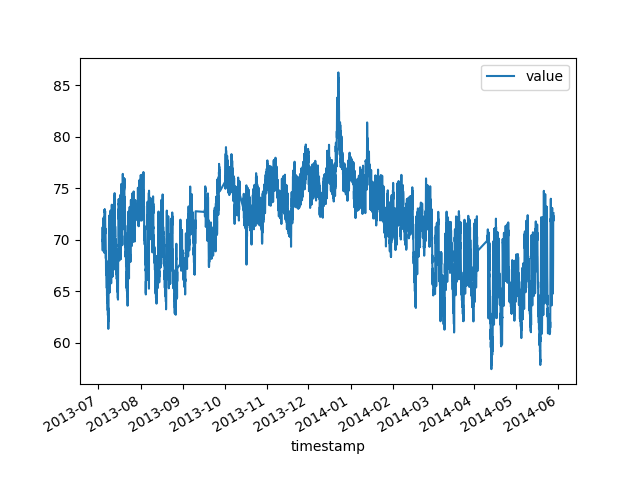

In [7]:
df.plot()
plt.show()

# 1. Construcción de modelo LSTM y detección de anomalías
* **a. Construcción de modelo básico LSTM (2 puntos). En este apartado se 
construirá un modelo con redes LSTM. La red tomará como entrada 
secuencias de datos (ventanas) del fichero con un tamaño determinado, por 
ejemplo [69.88, 71.22, 70.87] y devolverá una predicción del siguiente valor 
de la secuencia (p.ej. [68.86]).**  

---

In [11]:
# Crear las ventanas temporales
# Lo que se predice (y) es el "siguiente" valor de la secuencia
# pasando la ventana actual que tenemos.

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


In [22]:
# define input sequence
raw_seq = df['value'].to_numpy() # convertimos la columna del df a array numpy
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps 
n_steps = 3 # definicion del tamanio de la ventana
# split into samples
X, y = split_sequence(raw_seq, n_steps)
X, y

(array([[69.88083514, 71.22022706, 70.87780496],
        [71.22022706, 70.87780496, 68.95939994],
        [70.87780496, 68.95939994, 69.28355102],
        ...,
        [70.45571697, 72.37020644, 72.17295622],
        [72.37020644, 72.17295622, 72.04656545],
        [72.17295622, 72.04656545, 71.82522648]], shape=(7264, 3)),
 array([68.95939994, 69.28355102, 70.06096581, ..., 72.04656545,
        71.82522648, 72.58408858], shape=(7264,)))

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1 # analizamos una sola variable (temperatura)
X = X.reshape((X.shape[0], X.shape[1], n_features))
X

array([[[10],
        [20],
        [30]],

       [[20],
        [30],
        [40]],

       [[30],
        [40],
        [50]],

       [[40],
        [50],
        [60]],

       [[50],
        [60],
        [70]],

       [[60],
        [70],
        [80]]])

In [23]:
# define model
model = Sequential()
model.add(Input(shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [24]:
# fit model
model.fit(X, y, epochs=200)

Epoch 1/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 696.7002 
Epoch 2/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1873
Epoch 3/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1768
Epoch 4/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1551
Epoch 5/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1121
Epoch 6/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0818
Epoch 7/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0819
Epoch 8/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0750
Epoch 9/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0310
Epoch 10/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0447
Epoch 11/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0174
Epoch 12/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9851
Epoch 13/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9786
Epoch 14/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9323
Epoch 15/200
227/227 ━━━━━━━━━━━━━━━━━━━

In [28]:
# demonstrate prediction
#x_input = np.array([70.30750511, 70.24625215, 69.85490839])
x_input = np.array([71.88, 70.22, 72.87])

x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input)
print(yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[[72.1375]]
